# Language Classification

## Overview

My aim here is to build a language classifier for EU languages.

Proposed Approach:
1. Inspect test set
1. Create dataset for training / validation
1. Train / valid split
1. Numericalize
1. Build language classification model

## Setup

In [1]:
import sys
from pathlib import Path
import time

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import dill  # Better version of pickle, able to save objects with lambda expressions
import copy  # Used for making a deep copy of a model
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

import utils

In [2]:
start = time.time()
np.random.seed(1)

## Settings

In [3]:
PATH = Path('data')  # Directory for all data and temporary files
# Note: to run on the whole training set, specify PATH/'train' as the path.
# However, since that corpus is huge, the learning rate will have to be reduced.
# Also, the whole corpus will need a much higher training time.
TRAIN = PATH/'train_sampl'  # Directory for training text
TEST_FN = PATH/'test'  # Filename for test text
PATH_TMP = PATH/'tmp'  # Temporary directory to save progress

MIN_FREQ = 3  # We'll replace words with lower frequency with unknown
SEQ_LEN = 32  # Length of the sequences passed into our GRU

BS = 512  # Batch size for our RNN

EMB_SZ = 50  # Dimension of word embeddings
HIDDEN_SZ = 250  # Hidden layer dimension of the GRU
EMB_DROP = 0.25  # Dropout applied to embeddings
LAYER_DROP = 0.25  # Dropout applied after GRU

# List of languages
LANGS = list(map(lambda x: x.name, list(TRAIN.iterdir())))

assert torch.cuda.is_available()  # Notebook is written for GPU computations.

In [4]:
PATH_TMP.mkdir(parents=True, exist_ok=True)

## Clarify Goal

Let's first have a look at the test set we are trying to predict. It looks like a simple text classification task.

In [5]:
test = pd.read_csv(TEST_FN, sep = '\t', lineterminator='\n', header=None)
test.rename({0:'label', 1:'text'}, axis = 1, inplace=True)
test[test['label'] == 'en'].head()

,label,text
4992,en,"(BG) Thank you, Mr President."
4993,en,"(EL) Madam President, I agree and recognise Tu..."
4994,en,"(FI) Madam President, firstly, I would like to..."
4995,en,"(FI) Mr President, the Treaty of Lisbon will r..."
4996,en,"(FR) Madam President, one of the priorities of..."


Before going any further, let's apply some preprocessing. In particular, I apply the following steps:
1. Remove uninformative meta-comments, such as who is speaking.
1. Replace numbers with a generic *num* token. After all, the specific number shouldn't affect the classification results.
1. Create a special end-of-sentence (*eos*) token.
1. Replace all punctuation with a special *punc* token. 
1. Collapse adjecent white space. In other words, '&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;' becomes '&nbsp;'.

In [6]:
test['text'] = test['text'].apply(utils.preprocess)

Let's check a random English and German sentence after pre-processing.

In [7]:
print(test[test['label']=='en'].iloc[0]["text"])
print('---')
print(test[test['label']=='de'].iloc[0]["text"])

<punct> BG <punct> Thank you <punct> Mr President <eos>
---
<punct> BG <punct> Herr Kommissar <eos> Das Dokument <punct> das vom Europäischen Parlament angenommen werden soll <punct> ist in der Tat sehr wichtig <eos>


In [8]:
def word_count(x): return len(x.split())
def sentence_count(x): return len(x.split('<eos>')) - 1
test['text'].apply([sentence_count, word_count, len]).describe()

,sentence_count,word_count,len
count,20828.000000,20828.000000,20828.000000
mean,1.113837,26.071922,175.205541
std,0.851456,25.298060,167.062078
min,1.000000,3.000000,22.000000
25%,1.000000,15.000000,99.000000
50%,1.000000,23.000000,154.000000
75%,1.000000,33.000000,224.000000
max,77.000000,2184.000000,14069.000000


The target for our classification model has the following characteristics:
1. The vast majority of examples are a single sentence.
1. Most of the time, we have a decent number of words (15-33) to predict a language.
1. However, we can have as little as 3 words. This might pose a challenge if those words are not language-specific.
1. Content-wise, most sentences seem to be about parliamentary proceedings (my guess: proceedings of the EUP for more recent years).

## Preprocess Training/Validation Data

Our training set is of similar content, but in different format. Specifically, we don't have sentence-level chunks as in our test set, instead, we have files with different number of sentences. So we need to create a dataframe that resembles our test set.

First, we take all files for a language and concatenate them together.

In [9]:
# An example with English, we'll do all processing steps for all files below.
exampl = utils.concat_docs('en', TRAIN)
exampl[:200]

'<CHAPTER ID="010">\nPetitions: see Minutes\n<CHAPTER ID="010">\nPreventing trafficking in human beings (debate) \n<SPEAKER ID="209" NAME="President">\nThe next item is the debate on\n<P>\nthe oral question t'

Now we apply the same pre-processing as we did to our test set, and turn the whole corpus into a list of sentences.

In [10]:
# Example continued.
exampl = utils.txt2list(utils.preprocess(exampl[:1000]))
exampl[:3]

['Petitions <punct> see Minutes <eos>',
 'Preventing trafficking in human beings <punct> debate <punct> <eos>',
 'The next item is the debate on <eos>']

There is one last step we do. The test set had occasionally (although not often) multiple sentences. So we want to have, occasionally, multiple sentences in our training set as well. We can accomplish this by concatenating adjecent sentences together with a small probability (p = 0.02).

Let's apply all the above steps to all languages. I will also put everything into a dataframe with an extra column giving the language label.

In [11]:
dfs = []  # List to store data frames
for lang in LANGS:
    print(' '+lang+' ', end = "")
    txt = utils.concat_docs(lang, TRAIN)  # Concatenate all files
    txt = utils.preprocess(txt)  # Apply preprocessing described in test section
    txt = utils.txt2list(txt)  # Convert to list
    txt = utils.concat_random_sent(txt, p = 0.02)  # Concatenate random adjecent sentences
    temp_df = pd.DataFrame({'text':txt})  
    temp_df['label'] = lang
    dfs.append(temp_df)
df = pd.concat(dfs)[['label', 'text']]
df.reset_index(inplace=True, drop = True)
df.head()

 fi  et  it  lt  pt  lv  nl  pl  bg  en  sk  fr  da  hu  cs  sl  es  el  ro  de  sv 

,label,text
0,fi,Neuvoston toimittamat sopimustekstit <punct> k...
1,fi,pöytäkirja <eos>
2,fi,Suulliset kysymykset ja kirjalliset kannanotot...
3,fi,pöytäkirja <eos>
4,fi,Parlamentin puhemiehen puhe <eos>


In [12]:
df['text'].apply([sentence_count, word_count, len]).describe()

,sentence_count,word_count,len
count,1.643962e+06,1.643962e+06,1.643962e+06
mean,1.020197e+00,2.497108e+01,1.651713e+02
std,1.421575e-01,1.658897e+01,1.101502e+02
min,1.000000e+00,2.000000e+00,9.000000e+00
25%,1.000000e+00,1.300000e+01,8.700000e+01
50%,1.000000e+00,2.200000e+01,1.440000e+02
75%,1.000000e+00,3.300000e+01,2.180000e+02
max,4.000000e+00,7.910000e+02,5.184000e+03


Our resulting dataframe looks very similar to our test set. 

One difference: wee don't go quite as high on the maximum words and sentences. That's not going to matter though, as later on I will truncate all text at 32 words anyway.

In [13]:
del(dfs, temp_df, txt, exampl)
dill.dump(df, open(PATH_TMP/'df.pickle', mode = 'wb'))

In [14]:
#df = dill.load(open(PATH_TMP/'df.pickle', mode = 'rb'))

## Train/Validation Split

Let's split the data for training and validation. No big surprises here.

I use 1% of the data as validation. If that seems unusual, note that our dataset contains ~2 million rows, so our validation set will contain ~20k. I'm only using the validation set to monitor performance and check for over-fitting; 20k examples are more than enough for that.

In [15]:
len(df.index)

1643962

In [16]:
X_train, X_val, y_train, y_val = train_test_split(np.array(df['text']), np.array(df['label']), 
                                                  test_size=0.01, random_state=42)
y_train

array(['es', 'en', 'fi', ..., 'et', 'en', 'et'], dtype=object)

In [17]:
del(df)

## Numericalize

We need to turn our words into intiger indices. Later we use these indices to look up the embeddings for each word.

Let's start by counting the number of times a word appears in our training data.

In [18]:
words = Counter()
for row in tqdm(X_train, position=0, leave=False): words.update(row.split())
words.most_common(10)

[('<punct>', 3197124),
 ('<eos>', 1660401),
 ('de', 780623),
 ('a', 392042),
 ('<num>', 325462),
 ('la', 299425),
 ('en', 281276),
 ('que', 258093),
 ('in', 231871),
 ('the', 211452)]

No big surprises: the most frequent words are punctuation, end-of-sentence tokens, articles and prepositions.

Now we drop all words under 3 (what is specified under MIN_FREQ). Doing so is to make our embedding matrix smaller. Decreasing MIN_FREQ will increase the accuracy of our model, at a higher memory and computation cost.

We also add two special tokens: unknown (*unk*) and padding (*pad*). Unknown is any word not appearing in our list. These are any new words in our test or validation set, as well as the words we previously dropped due to low frequence. Padding will later be used to make all sequences equal length. 

In [19]:
words = {k:v for k, v in tqdm(words.items(), leave = False) if v >= MIN_FREQ}
words = sorted(words, key=words.get, reverse=True)
words = ['<unk>','<pad>'] + words

In [20]:
vocab_size = len(words)
vocab_size

430864

We have more than 300k unique words. Now we need to create a mapping from words to integers (and back). I'll use the dictionaries below to do so.

Note that unknown is mapped to 0, and padding is mapped to 1 (they are the first two elements by construction).

In [21]:
word2idx = defaultdict(lambda: 0, {o:i for i,o in enumerate(words)})
idx2word = defaultdict(lambda: '<unk>', {i:o for i,o in enumerate(words)})

Here is the first sentence of the training set converted into indices:

In [22]:
print([word2idx[w] for w in X_train[0].split()])

[15827, 4, 496, 2, 2164, 1552, 3985, 1553, 140, 7, 287, 3550, 2, 73, 17360, 5, 7, 21854, 30, 7, 399, 8, 9, 22, 242273, 3]


Now we apply the above to the whole training set. I also truncate long sentences at 32 words -- that should be more than enough to classify a language, and having more words would needlessly slow down computation time.

I also pad sentences that are shorter than 32 with the special padding character. This way, all example are of equal length, making subsequent computations easier.

In [23]:
X_train = utils.numericalize(X_train, word2idx, maxlen = SEQ_LEN)
X_val = utils.numericalize(X_val, word2idx, maxlen = SEQ_LEN)
print(X_train.shape)

(1627522, 32)


Of course, we can alway convert our indices back. Below is our first training example converted back to text.

In [24]:
utils.de_numericalize(X_train[:1], idx2word)

['Después de todo <punct> queremos tener cierto control sobre la política agrícola <punct> las subvenciones a la exportación y la forma en que se distribuyen <eos>']

We'll also replace languages with contiguous integers.

In [25]:
lang2idx = defaultdict(lambda: 0, {o:i for i,o in enumerate(LANGS)})
idx2lang = defaultdict(lambda: '<unk>', {i:o for i,o in enumerate(LANGS)})

In [26]:
print(y_train[:5])  # Before
y_train = np.array([lang2idx[x] for x in y_train])
y_val = np.array([lang2idx[x] for x in y_val])
print(y_train[:5])  # After

['es' 'en' 'fi' 'it' 'da']
[16  9  0  2 12]


In [27]:
with open(PATH_TMP/'numericalized.pickle', mode = 'wb') as f:
    dill.dump([words, vocab_size, word2idx, idx2word, X_train, X_val, y_train, y_val], f)

In [28]:
#with open(PATH_TMP/'numericalized.pickle', mode = 'rb') as f:
#    (words, vocab_size, word2idx, idx2word, X_train, X_val, y_train, y_val) = dill.load(f)

In [29]:
end = time.time()
print(f'Time after pre-processing : {(end - start)/60} mins')

Time after pre-processing : 2.0694626132647196 mins


## Define Dataloaders

We take our training and validation data, convert them from numpy arrays to torch tensors, and put them in dataloaders. 

In [30]:
X_train = torch.from_numpy(X_train).type(torch.int64)
y_train = torch.from_numpy(y_train).type(torch.int64)
X_val = torch.from_numpy(X_val).type(torch.int64)
y_val = torch.from_numpy(y_val).type(torch.int64)

train_dl = DataLoader(TensorDataset(X_train, y_train), batch_size=BS, shuffle = True)
valid_dl = DataLoader(TensorDataset(X_val, y_val), batch_size=BS, shuffle = False)

## Define Model

Our model is a relatively simple recurrent network. We go through our sentence word by word, look it up in our embedding matrix, and feed it into our GRU. We apply a linear layer to the final output of our GRU, which gives our predictions. 

![Model Illustration](model_illustration.jpg)

I also added dropout for regularization. I applied it at two points: first after our embedding lookup, and then before the final linear layer.

Why not use something more complicated (say, a bidirectional LSTM)? It's simply not needed. The task is relatively simple, no need for an overkill.

In [31]:
class Lang_Detect(nn.Module):
    def __init__(self, emb_sz = EMB_SZ, vocab_size = vocab_size,
                 hidden_sz = HIDDEN_SZ, out_sz = len(LANGS), 
                 emb_drop = EMB_DROP, layer_drop = LAYER_DROP):
        super().__init__()
        self.hidden_sz = hidden_sz
        self.emb = nn.Embedding(vocab_size, emb_sz)
        self.emb_drop = nn.Dropout(emb_drop)
        self.emb.weight.data.uniform_(-0.05, 0.05)  # Initialize embeddings
        self.gru = nn.GRU(emb_sz, hidden_sz)
        self.layer_drop = nn.Dropout(layer_drop)
        self.lout = nn.Linear(hidden_sz, out_sz)        
                
    def forward(self, seq): 
        bs, _ = seq.shape
        h =  torch.zeros(1, bs, self.hidden_sz).cuda()  # Initial empty hidden state
        embedded = self.emb(seq).transpose(0, 1)
        outputs, _ = self.gru(self.emb_drop(embedded), h)
        output = self.lout(self.layer_drop(outputs[-1]))
        return output

In [32]:
model = Lang_Detect().cuda()

I use standard cross-entropy as the loss function.

In [33]:
loss_func = nn.CrossEntropyLoss().cuda()

## Fit Model

I create a special class that helps with fitting the model. It is model agnostic, and can help fit other pytorch models as well.

First a helper function that calculates the loss for a batch, and updates parameters.

In [34]:
def loss_batch(xb, yb, model, loss_func, opt=None):
    
    '''Calculates the loss for a minibatch, and (if opt is given) updates parameters'''
    # Taken from: https://github.com/fastai/fastai_v1/blob/master/dev_nb/001a_nn_basics.ipynb

    loss = loss_func(model(xb.cuda()), yb.cuda())
    if opt is not None:  # Update parameters
        loss.backward(); opt.step(); opt.zero_grad()
        
    return loss.item(), len(xb)

The Learner class below has 3 methods to help the fitting process:
- lr_find: to find the optimal learning rate,
- fit: to fit the model,
- predict: to predict on new data,
- plot_loss: plot the training loss.

The inspiration for this class is the [fast.ai](https://github.com/Gokkulnath/fastai-v0.7) library (version 0.7, now depreciated), which contains similar classes for fitting pytorch models.

I use the Adam optimizer with standard settings.

In [35]:
class Learner(object):
    
    def __init__(self, model, loss_func, train_dl = None, valid_dl = None):
        self.model = model
        self.loss_func = loss_func
        self.train_dl = train_dl
        self.valid_dl = valid_dl
        self.losses = []
    
    def lr_find(self, start = 1e-6, end = 1e3, exp_smooth_param = 0.95):
        
        '''Learning rate finder, detailed explanation below.'''
        
        old_state_dict = copy.deepcopy(self.model.state_dict())  # Save old parameters
        self.model.train()
        lr = start; lrs = []; losses = []; i = 0
        for xb,yb in tqdm(self.train_dl, leave = False,
                         position = 0):
            opt = optim.Adam(self.model.parameters(), lr=lr)
            loss, _ = loss_batch(xb, yb, self.model, self.loss_func, opt)
            lrs.append(lr), losses.append(loss)
            if (lr > end) or (i > 10 and loss > 3*np.mean(losses[:i])):
                break  # Stop if losses shoot up higher than the average loss so far
            lr *= 1.03; i += 1        
        self.losses = losses  # Previous losses aren't relevant for plotting
        self.plot_loss(x = lrs, xlog=True, exp_smooth_param = exp_smooth_param)
        self.losses = []  # Reset list
        # Note: we don't want to keep the parameters, as at the end of the algorithm
        # very high learning rates are used, and the loss is high. Hence, we
        # reset it
        self.model.load_state_dict(old_state_dict)
        
    def plot_loss(self, x = None, xlog = False, exp_smooth_param = 0.95):
        '''Plots training loss. Each datapoint is a mini-batch.'''
        # Note: plots losses from all epochs (since the last lr_find call)
        
        # Use exponental smoothing with parameter exp_smooth_param
        y_smooth = utils.exp_smooth(np.array(self.losses), exp_smooth_param)
        f, ax = plt.subplots(figsize=(5, 5))
        if xlog:  # Use log on both scales
            ax.set(yscale = 'log', xscale = 'log')  
        else: 
            ax.set(yscale = 'log')
        if x is not None:
            ax = plt.plot(x, y_smooth)
        else:
            ax = plt.plot(y_smooth)     
            
    def fit(self, lr, epochs):
        
        '''Fits model for specified number of epochs, with learning rate lr.'''
        
        opt = optim.Adam(self.model.parameters(), lr=lr)
        
        for epoch in range(epochs):
        
            # Fit model to training data
            self.model.train()  # Enables dropout
            losses, nums = zip(*[loss_batch(xb, yb, self.model, self.loss_func, opt) 
                                 for xb,yb in tqdm(self.train_dl, leave = False, position = 0)])
            train_loss = np.sum(np.multiply(losses,nums)) / np.sum(nums)
            self.losses = self.losses+list(losses)
            
            # Apply model to validation data
            if self.valid_dl != None:             
                self.model.eval()  # Disables dropout
                with torch.no_grad():  # No gradient calculations
                    
                    # Note: loss_batch doesn't update parameters if not supplied with
                    # an optimizer. So this loop only calculates the loss.
                    losses,nums = zip(*[loss_batch(xb, yb, self.model, self.loss_func)
                                        for xb,yb in valid_dl])
                    val_loss = np.sum(np.multiply(losses,nums)) / np.sum(nums)
                    
                    # Also compute validation accuracy
                    val_preds = self.predict(self.valid_dl)
                    y_val = self.valid_dl.dataset.tensors[1]
                    acc = utils.accuracy(val_preds, y_val) 
                    # Note: in this case, refactoring code means we run the model through
                    # the validation set twice. That's okay - the validation set is small.
                    
                print(f'Epoch {epoch}. Training loss: {train_loss}. ' +
                      f'Validation loss: {val_loss}. Accuracy: {acc}')  
            else:  
                print(f'Epoch {epoch}. Training loss: {train_loss}.')
                        
    def predict(self, dl):
        '''Gives predictions on supplied dataloader, concatenates results.'''
        self.model.eval()  # No dropout
        with torch.no_grad():  # No gradient calculations
            res = [self.model(xb.cuda()).argmax(dim = -1).view(-1) for 
                   xb, _ in tqdm(dl, leave = False, position = 0)]
        return torch.cat(res)

In [36]:
learn = Learner(model, loss_func, train_dl, valid_dl)

Let's use our untrained model to predict the validation set. As expected, it's about as good as chance.

In [37]:
preds = learn.predict(valid_dl)
utils.accuracy(preds, y_val)

0.060644768856447685

In order to fit our model, we have to give it a learning rate. A learning rate that's too high will not converge on a minimum, a learning rate that's too low will take too long to find one.

The lr_find method helps us pick a good learning rate, neither too high, nor too low. Originally, the idea was mentioned in [this](https://arxiv.org/abs/1506.01186) paper, a nice blog post explaining the concept is [here](https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html).

We start fitting our neural net with a very low learning rate (1e-6). Then after each minibatch, we increase it a little (by 3%). We do it until we reach a rate that's too high (1e3), or until our loss sharply increases.

What tends to happen: at low learning rates, our loss doesn't improve. At a certain point, it decreases steeply. However, moving past this optimal range, or loss shoots up as we are taking update steps too big.

Here is our (smoothed) loss plotted against the learning rate. Note that we don't want to pick the minimum: at that point the learning rate is already too high. Instead we want to pick a point where we are improving at a good rate.

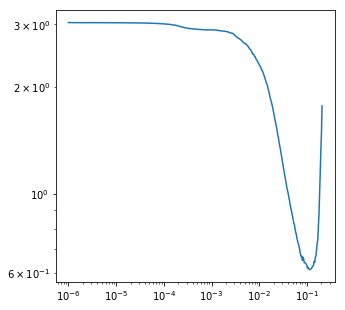

In [38]:
learn.lr_find()

To err on the safe side, I choose a relatively low rate. Training this network is relatively fast anyway.

In [39]:
lr = 3e-3

  0%|          | 1/3179 [00:00<07:46,  6.81it/s]

Epoch 0. Training loss: 0.11657766904380926. Validation loss: 0.02260163407908739. Accuracy: 0.9931265206812652


  0%|          | 1/3179 [00:00<06:31,  8.11it/s]

Epoch 1. Training loss: 0.018917409263971473. Validation loss: 0.020783180302947107. Accuracy: 0.9937956204379562


  0%|          | 1/3179 [00:00<06:38,  7.98it/s]

Epoch 2. Training loss: 0.01482421040128954. Validation loss: 0.019819382250018943. Accuracy: 0.9940389294403893


  0%|          | 1/3179 [00:00<06:35,  8.04it/s]

Epoch 3. Training loss: 0.013531177709874486. Validation loss: 0.02008023750027891. Accuracy: 0.9940997566909976


Epoch 4. Training loss: 0.012697562721611731. Validation loss: 0.019940753977229126. Accuracy: 0.994647201946472


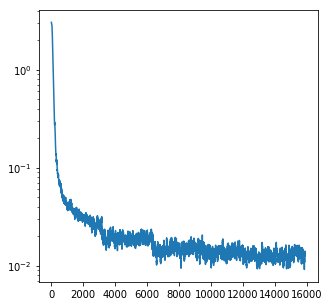

In [40]:
learn.fit(lr, 5)
dill.dump(learn.model.state_dict(), open(PATH_TMP/'model0.pickle', mode = 'wb'))
learn.plot_loss()

We are already achieving good results (XXX% accuracy on the validation set). Let's decrease our learning rate by two orders of magnitude and fit just a little more to fine-tune our model.

  0%|          | 1/3179 [00:00<06:25,  8.24it/s]

Epoch 0. Training loss: 0.0115412798811946. Validation loss: 0.019156136184278194. Accuracy: 0.994647201946472


  0%|          | 1/3179 [00:00<06:25,  8.25it/s]

Epoch 1. Training loss: 0.011265515723662653. Validation loss: 0.019081519768910978. Accuracy: 0.9947688564476885


  0%|          | 1/3179 [00:00<06:26,  8.23it/s]

Epoch 2. Training loss: 0.011112661853104321. Validation loss: 0.019017652293481385. Accuracy: 0.9948296836982968


  0%|          | 1/3179 [00:00<06:27,  8.21it/s]

Epoch 3. Training loss: 0.01103196767881939. Validation loss: 0.018940332644322204. Accuracy: 0.9948296836982968


Epoch 4. Training loss: 0.010977560240663056. Validation loss: 0.01890077690646016. Accuracy: 0.9948296836982968


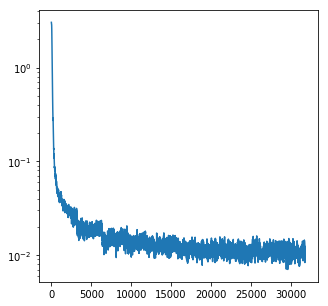

In [41]:
learn.fit(lr/1e2, 5)
dill.dump(learn.model.state_dict(), open(PATH_TMP/'model1.pickle', mode = 'wb'))
learn.plot_loss()

In [42]:
end = time.time()
print(f'Time after training : {(end - start)/60} mins')

Time after training : 13.165116735299428 mins


## Predict Test Set

In [43]:
X_test = utils.numericalize(np.array(test['text']), word2idx)
y_test = np.array([lang2idx[x] for x in test['label']])

In [44]:
X_test = torch.from_numpy(X_test).type(torch.int64)
y_test = torch.from_numpy(y_test).type(torch.int64)

test_dl = DataLoader(TensorDataset(X_test, y_test), batch_size=BS, shuffle = False)

In [45]:
preds = learn.predict(test_dl)
utils.accuracy(preds, y_test)

0.9987036681390435

In [46]:
test['pred'] = [idx2lang[x] for x in utils.conv2np(preds)]
test['correct'] = (test['pred'] == test['label'])*1
inc_total = len(test.index)-sum(test['correct'])
print(f"Total number of mispredicted: {inc_total} out of {len(test.index)}")
test.groupby(by = 'label')['correct'].agg('mean').sort_values()

Total number of mispredicted: 27 out of 20828


label
ro    0.994612
cs    0.995000
sk    0.996771
da    0.997000
hu    0.998000
lt    0.998000
sl    0.998000
lv    0.998979
pt    0.999000
pl    0.999000
sv    0.999000
et    0.999000
it    1.000000
fi    1.000000
nl    1.000000
es    1.000000
en    1.000000
el    1.000000
de    1.000000
fr    1.000000
bg    1.000000
Name: correct, dtype: float64

In [47]:
def print_incorrect(i = None, lang = None):
    
    flag = (test['correct']==0)
    if lang is not None:
        flag = flag  & (test['label']==lang)
    if i is not None:
        idx = test[flag].index[i]
    else:
        idx = test[flag].sample(1).index
    print(f'class: {test.iloc[idx]["label"]}, ', end = "")
    print(f'predicted: {test.iloc[idx]["pred"]}, ', end = "")
    print(f'text: {utils.de_numericalize(X_test.numpy()[idx:(idx+1)], idx2word)}, ', end = "")
    print('\n')

In [48]:
for i in range(inc_total): print_incorrect(i)

class: cs, predicted: el, text: ['<unk> a <unk> <eos>'], 

class: cs, predicted: sk, text: ['<unk> k <num> <unk> se základnou <unk> <unk> v <unk> <eos>'], 

class: cs, predicted: sk, text: ['Správa projektu však není v pořádku <eos>'], 

class: cs, predicted: lv, text: ['<unk> <punct> <unk> projektu Galileo <eos>'], 

class: cs, predicted: sk, text: ['Za <unk> let od roku <num> trh s <unk> hrami dramaticky vzrostl <eos>'], 

class: da, predicted: fr, text: ['De fremsætter en <unk> profeti <eos>'], 

class: da, predicted: es, text: ['Hans samtidige vidste <punct> at han dermed mente <unk> <eos>'], 

class: da, predicted: en, text: ['Their will is the law <punct> not only at home <punct> but as to the concerns of every nation <eos> <eos> They have swept away the very constitutions under which the <unk>'], 

class: et, predicted: el, text: ['<unk> finantsturgudel <eos>'], 

class: hu, predicted: lt, text: ['A tudományos ismeretek <unk> <eos>'], 

class: hu, predicted: el, text: ['<unk> ug

In [49]:
end = time.time()
print(f'Total time : {(end - start)/60} mins')

Total time : 13.173734060923259 mins


## Try with own example text

In [50]:
# These examples are in English, German and Hungarian respectively
own_examples = ["Let's see if this sentence gets classified correctly.", 
 'Das können wir auch ausprobieren',
 'Ezt a szöveget is megpróbáljuk lefordítani.']

In [51]:
def predict_own(ex_list, learn_obj = learn, langmapper = idx2lang):
    y = torch.zeros(len(ex_list))  # 1. Dummy y for data loader
    exampl = np.array(list(map(utils.preprocess, ex_list)))  # 2. Preprocess, convert to numpy
    idxs = utils.numericalize(exampl, word2idx)  # 3. Numericalize
    idxs = torch.from_numpy(idxs).type(torch.int64) # 4. Convert to torch tensor
    dl = DataLoader(TensorDataset(idxs, y), batch_size=BS, shuffle = False)  # 6. Put in dataloader
    res = learn_obj.predict(dl)  # 7. Predict language index
    res = [langmapper[x] for x in utils.conv2np(res)]  # 8. Map index to language
    return res

In [52]:
predict_own(own_examples)

['en', 'de', 'hu']